# TOF data
Data taken at intervals of $T=0.1ms$, where $T$ represents the period of free flight after trapping. Captured in sequences of 10 ranging from 0.1ms to 1.0ms. 

In [1]:
import os
import sys
sys.path.append("../")
import datarun
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

In [2]:
d = datarun.Experiment(
    vstart = .1,
    vend = 1.0,
    vstep = .1, 
    idx_start = 11,
    datapath = "../data/mar02/",
    numtrials = 10,
    mask=0.25
)

|████████████████████████████████████████| 100/100 [100%] in 1:57.2 (0.85/s)    


In [21]:
sigma_times_x = d.structure_data(lambda d : d.popt_x[2]**2)
sigma_times_y = d.structure_data(lambda d : d.popt_y[2]**2)

def purge_outliers(str_dat):
    ct = 0
    for arr in str_dat.values():
        mean = np.mean(arr)
        std = np.std(arr)
        for val in arr:
            if np.abs(val-mean) > 2*std:
                ct += 1
                arr.remove(val)

    return ct

print("x:", purge_outliers(sigma_times_x))    
print("y:", purge_outliers(sigma_times_y))    

means_x = [np.mean(arr) for arr in sigma_times_x.values()]
errs_x = [np.std(arr) for arr in sigma_times_x.values()]/np.sqrt(10)
means_y = [np.mean(arr) for arr in sigma_times_y.values()]
errs_y = [np.std(arr) for arr in sigma_times_y.values()]/np.sqrt(10)
time_list = np.array(list(sigma_times.keys()))

x: 2
y: 8


In [22]:
popt_x, pcov_x = curve_fit(lambda x,a,b:a*x**2+b, time_list, means_x, sigma=errs_x)
popt_y, pcov_y = curve_fit(lambda x,a,b:a*x**2+b, d.vlist, means_y, sigma=errs_y)

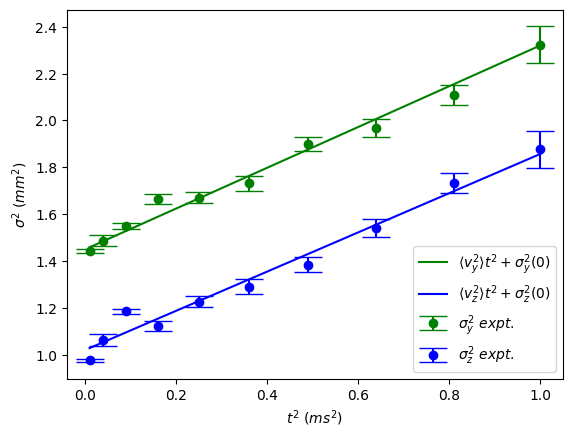

In [50]:
scale = 1e3
plt.errorbar(time_list**2, scale**2*np.array(means_x), yerr = np.array(errs_x)*scale**2, linestyle = "None", c = 'g', capsize=10, marker = "o", label = r"$\sigma_y^2 \ expt.$")
plt.errorbar(time_list**2, scale**2*np.array(means_y), yerr = np.array(errs_x)*scale**2, linestyle = "None", c = 'b', capsize=10, marker = "o", label = r"$\sigma_z^2 \ expt.$")

xaxis = np.linspace(min(d.vlist), max(d.vlist), 100)
plt.plot(xaxis**2, scale**2*(popt_x[0]*xaxis**2+popt_x[1]), c="g", label = r"$\langle v_y^2\rangle t^2+\sigma_y^2(0)$")
plt.plot(xaxis**2, scale**2*(popt_y[0]*xaxis**2+popt_y[1]), c="b", label = r"$\langle v_z^2\rangle t^2+\sigma_z^2(0)$")

plt.xlabel(r"$t^2 \ (ms^2)$")
plt.ylabel(r"$\sigma^2 \ (mm^2)$")
plt.legend(loc = "lower right")
plt.savefig("../figures/TOF_updated_scaling.png", dpi = 300)

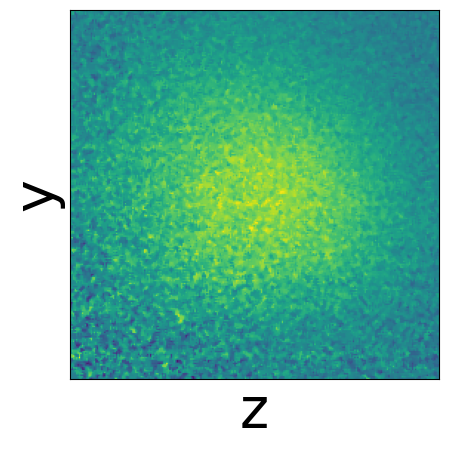

In [49]:
plt.imshow(d.data[5].blob)
plt.xlabel("z", fontsize = 40)
plt.ylabel("y", fontsize = 40)
plt.xticks([])
plt.yticks([])
plt.savefig("../figures/TOF_ex_blob.png")

In [31]:
pcov_x

array([[ 2.93802181e-15, -3.30129894e-16],
       [-3.30129894e-16,  1.30614431e-16]])

In [7]:
v_err = np.sqrt(pcov[0][0])

In [8]:
popt

array([8.3756427e-07, 1.0198907e-06])

In [9]:
v_rms = np.sqrt(popt[0])*1e3*np.sqrt(3)
v_err = np.sqrt(pcov[0][0])*3*1e6/(np.sqrt(9))*3

In [33]:
v_rms_x = np.sqrt(popt_x[0])*1e3*np.sqrt(3)
v_rms_y = np.sqrt(popt_y[0])*1e3*np.sqrt(3)

In [34]:
v_rms_x**2*.0391/(3*8.315)*1e3

4.095578103452156

In [35]:
v_rms_y**2*.0391/(3*8.315)*1e3

3.9385162896021324

First, we have $\langle (x+vt)^2 \rangle = \langle x^2 \rangle + \langle v^2\rangle t^2$, using $\langle v \rangle = 0$, and thus the fit parameter $a$ gives the RMS velocity. Plugging this into the Maxwell-Bolzmann distribution,
$$
v_{rms} = \sqrt{\frac{3RT}{M}} \Rightarrow T = \frac{v_{rms}^2 M}{3R}
$$

$$
\sqrt{v_{rms}^2+\delta v} \approx \sqrt{v_{rms}^2}+\frac{\delta v}{2\sqrt{v_{rms}^2}}
$$

In [10]:
v_rms**2*.0391/(3*8.315)*1e3

3.9385162896021324

In [42]:
v_err*.0391/(3*8.315)*1e3

0.47824419566555687

In [43]:
v_rms**2

2.512692809312665

In [44]:
v_err/v_rms

0.19248050978350345

In [45]:
v_err/(2*np.sqrt(v_rms))

0.12116902513518063

In [46]:
v_rms

1.585147567046256

In [47]:
v_err

0.3051100117871436